In [1]:
import mat73
import scipy
import scipy.io as sio # cannot use for v7.3 mat file
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
butter_lowpass_filter: Filter out frequencies higher than lowcut
butter_highpass_filter: Filter out frequencies lower than highcut
butter_bandpass_filter: Keep only frequencies between lowcut and highcut
"""
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, lowcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  b, a = butter(order, low, btype='low')
  y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
  return y

def butter_highpass_filter(data, highcut, fs, order):
  nyq = fs/2
  high = highcut/nyq
  b, a = butter(order, high, btype='high')
  y = filtfilt(b, a, data) # zero-phase filter
  return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  high = highcut/nyq
  b, a = butter(order, [low, high], btype='band')
  # demean before filtering
  meandat = np.mean(data, axis=1)
  data = data - meandat[:, np.newaxis]
  y = filtfilt(b, a, data)
  return y

In [3]:
"""
extractEpoch3D: extract and baseline-correct time-locked epochs from continuous EEG data
baseline(used for correction and normalization): [-200, 0]
frame: [-200, 600]
"""
def extractEpoch3D(data, event, srate, baseline, frame, opt_keep_baseline):
  # extract epoch from 2D data into 3D [ch x time x trial]
  # input: event, baseline, frame
  # extract epoch = baseline[0] to frame[2]

  # for memory pre-allocation
  if opt_keep_baseline == True:
    begin_tmp = int(np.floor(baseline[0]/1000*srate))
    end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
  else:
    begin_tmp = int(np.floor(frame[0]/1000*srate))
    end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)
  
  epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
  nth_event = 0

  for i in event:
    if opt_keep_baseline == True:
      begin_id = int(i + np.floor(baseline[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))
    else:
      begin_id = int(i + np.floor(frame[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))
    
    tmp_data = data[:, begin_id:end_id]

    begin_base = int(np.floor(baseline[0]/1000 * srate))
    end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
    base = np.mean(tmp_data[:, begin_base:end_base], axis=1)

    rmbase_data = tmp_data - base[:, np.newaxis]
    epoch3D[:, :, nth_event] = rmbase_data
    nth_event = nth_event + 1

  return epoch3D

In [4]:
EEG = mat73.loadmat("C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Python/data/s48.mat")

1. For using mat73, data distributor should save mat file using '-v7.3'
2. After loading a file, data filed names are displayed using keys() function, otherwise it prints all names and values at the same time.
3. This dataset consists of structural cell array so their should be a few indicies

In [5]:
EEG.keys()
EEG['RSVP'].keys()
EEG['test'][0].keys()
EEG['train'][0].keys()

dict_keys(['chanlocs', 'data', 'markers_seq', 'markers_target', 'nbTrials', 'nbTrials_nontarget', 'nbTrials_target', 'online_acc', 'srate', 'text_result', 'text_to_spell'])

In [6]:
# Parameters
baseline = [-200, 0] # in ms
frame = [0, 600] # in ms

In [7]:
"""
EEG preprocessing and epoch extraction 
- apply bandpass filtering
- extract target and non-target epochs
- stack them acorss multiple calibration sessions
- store then in 3D arrays
"""
for n_calib in range(len(EEG['train'])):
  data = np.asarray(EEG['train'][n_calib]['data'])
  srate = EEG['train'][n_calib]['srate']
  data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
  markers = EEG['train'][n_calib]['markers_target']

  targetID = np.where(markers==1)[0]
  nontargetID = np.where(markers==2)[0]

  tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, False)
  tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, False)
  if n_calib == 0:
    targetEEG = tmp_targetEEG
    nontargetEEG = tmp_nontargetEEG
  else:
    targetEEG = np.dstack((targetEEG, tmp_targetEEG))
    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))
  
print(targetEEG.shape)
print(nontargetEEG.shape)

C:\Users\ryoii\AppData\Local\Temp\ipykernel_3880\2144299015.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)


(32, 307, 300)
(32, 307, 1500)


In [8]:
"""
preprocessing pipeline for test data
"""
for n_test in range(len(EEG['test'])):
  data = np.asarray(EEG['test'][n_test]['data'])
  srate = EEG['test'][n_test]['srate']
  data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
  markers = EEG['test'][n_test]['markers_target']

  targetID = np.where(markers==1)[0]
  nontargetID = np.where(markers==2)[0]

  tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, False)
  tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, False)
  if n_test == 0:
    targetEEG = tmp_targetEEG
    nontargetEEG = tmp_nontargetEEG
  else:
    targetEEG = np.dstack((targetEEG, tmp_targetEEG))
    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

print(targetEEG.shape)
print(nontargetEEG.shape)

C:\Users\ryoii\AppData\Local\Temp\ipykernel_3880\2144299015.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)


(32, 307, 840)
(32, 307, 4200)


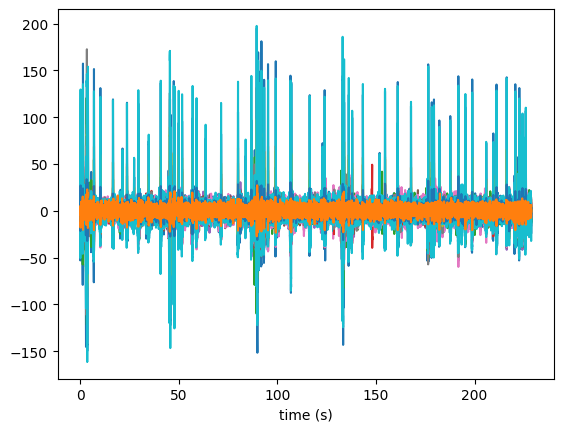

In [9]:
"""
Plot filtered EEG signals over time from one training session
"""
data = EEG['train'][0]['data']
srate = EEG['train'][0]['srate']
y = np.asarray(data)
y = butter_bandpass_filter(y, 1, 40, srate, 4)
yt = np.transpose(y)
x=range(yt.shape[0]) / srate

plt.plot(x, yt)
plt.xlabel('time (s)')
plt.show()

Draw ERP

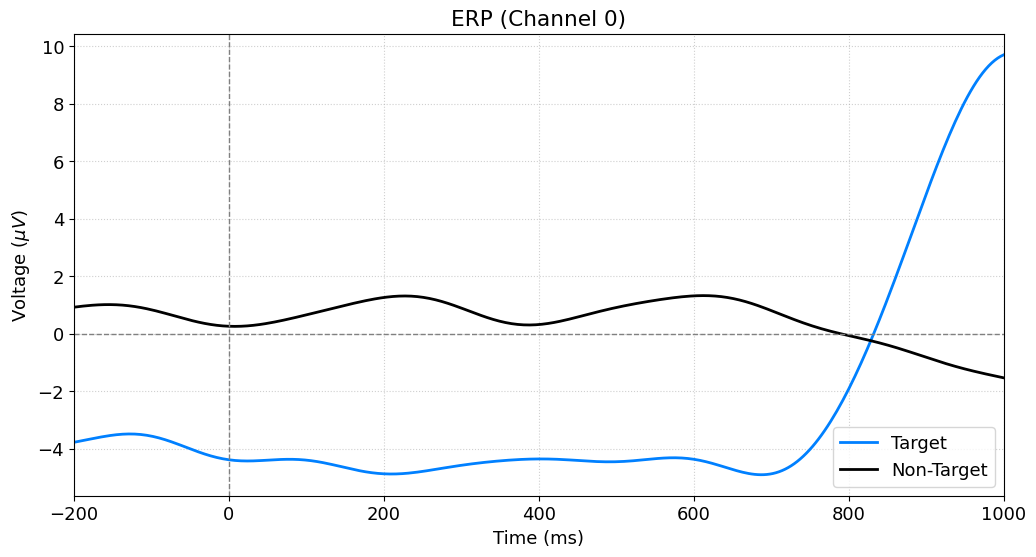

In [10]:
"""
Plot the ERP for one channel
"""
import os
import matplotlib.pyplot as plt
import numpy as np

# === Compute average across trials for one channel (e.g., channel 0) ===
channel_idx = 0  # Change to 1 if you want the second channel

erp_target = np.mean(targetEEG[channel_idx, :, :], axis=1)      # shape: [time]
erp_nontarget = np.mean(nontargetEEG[channel_idx, :, :], axis=1)

# === Time vector ===
t = np.linspace(-200, 1000, erp_target.shape[0])

# === PLOT ===
plt.rcParams.update({'font.size': 13})
output_dir = "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/result"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.plot(t, erp_target, color=[0, 0.5, 1], linewidth=2, label='Target')
plt.plot(t, erp_nontarget, color=[0, 0, 0], linewidth=2, label='Non-Target')

plt.xlabel('Time (ms)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.title(f'ERP (Channel {channel_idx})')
plt.xlim([-200, 1000])
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

# === Save ===
filename = f'ERP_Channel_{channel_idx}.png'
save_path = os.path.join(output_dir, filename)
# plt.savefig(save_path)
plt.show()


In [11]:

import mne
print(__doc__)


Plot the ERP for one channel



In [12]:
"""
Extract and list the names of all EEG channels in the biosemi32 standard montage using mne
"""
# --- Your existing code ---
# (Assuming avg_target is a numpy array with shape (32, n_samples))
# For this example, let's create a placeholder for avg_target
avg_target = np.random.randn(32, 500) 

biosemi_montage = mne.channels.make_standard_montage('biosemi32')
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=512., ch_types='eeg')
fake_evoked = mne.EvokedArray(avg_target, fake_info)
fake_evoked.set_montage(biosemi_montage)
# --- End of your code ---


# Get the dictionary of electrode positions from the montage
# The result is a dictionary where keys are channel names and values are XYZ coordinates
positions = biosemi_montage.get_positions()

# 'positions' is a dictionary with keys like 'ch_pos', 'coord_frame'. 
# We are interested in 'ch_pos'.
channel_positions = positions['ch_pos']


# Print in a nicely formatted way
print("--- BioSemi32 Electrode Positions (in meters) ---")
all_positions = []
for channel_name, xyz in channel_positions.items():
    # The 'xyz' variable is a numpy array with the [x, y, z] coordinates
    all_positions.append(channel_name)

all_positions

--- BioSemi32 Electrode Positions (in meters) ---


['Fp1',
 'AF3',
 'F7',
 'F3',
 'FC1',
 'FC5',
 'T7',
 'C3',
 'CP1',
 'CP5',
 'P7',
 'P3',
 'Pz',
 'PO3',
 'O1',
 'Oz',
 'O2',
 'PO4',
 'P4',
 'P8',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'AF4',
 'Fp2',
 'Fz',
 'Cz']

In [14]:
"""
Create a mock ERP object `Evoked` wtih BioSemi32 EEG electrode positions
"""
biosemi_montage = mne.channels.make_standard_montage('biosemi32')
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=512.,ch_types='eeg')

fake_evoked = mne.EvokedArray(avg_target, fake_info)
fake_evoked.set_montage(biosemi_montage)

<Evoked | '' (average, N=1), 0 – 0.97461 s, baseline off, 32 ch, ~174 KiB>

Text(0.5, 1.0, 'MNE')

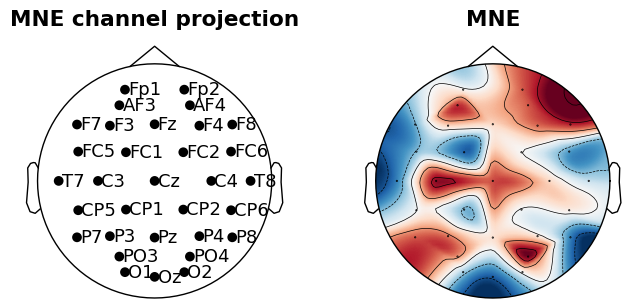

In [15]:
# create a two-panel figure with some space for the titles at the top
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
# we plot the channel positions with default sphere - the mne way
fake_evoked.plot_sensors(axes=ax[0], show=False, show_names=True)
# add titles
ax[0].set_title('MNE channel projection', fontweight='bold')

mne.viz.plot_topomap(np.mean(fake_evoked.data, axis=1), fake_evoked.info, axes=ax[1], show=False)
ax[1].set_title('MNE', fontweight='bold')

P300 speller letter detect 

In [16]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [17]:
"""
decimation_by_avg: Downsample by averaging (temporal resolution reduction)
reshape: convert 3D to 2D
shuffle: randomize order for fair training
"""

def decimation_by_avg(data, factor):
  """Function for replacing each sequence of previous factor samples with their average"""
  # for example, frame [0, 800]ms -> 17samples (Krusienski et al., 2006)
  # data.shape = [ch, time, trial]
  ratio_dsample = factor
  n_ch, n_frame, n_trial = data.shape

  #print(n_frame)
  decimated_frame = int(np.floor(n_frame/ratio_dsample))
  #print(decimated_frame)

  # memory pre-allocation
  decimated_data = np.zeros((n_ch, decimated_frame, n_trial))
  #print(decimated_data.shape)

  for i in range(n_trial):
    for j in range(decimated_frame):
      cur_data = data[:, :, i]
      decimated_data[:, j, i] = np.mean(cur_data[:, j*ratio_dsample:(j+1)*ratio_dsample], axis=1)

  return decimated_data


down_target = decimation_by_avg(targetEEG, 24)
down_nontarget = decimation_by_avg(nontargetEEG, 24)

ch_target, frame_target, trial_target = down_target.shape
ch_nontarget, frame_nontarget, tiral_nontarget = down_nontarget.shape
feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target))
feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, tiral_nontarget))

# feature: [n_samples, n_features]
feat_target = feat_target.transpose() 
feat_nontarget = feat_nontarget.transpose()
# y: 1 for target and -1 for nontarget
y_target = np.ones((feat_target.shape[0],1))
y_nontarget = -np.ones((feat_nontarget.shape[0],1))

feat_train = np.vstack((feat_target, feat_nontarget))
y_train = np.vstack((y_target, y_nontarget))

idx_train = np.arange(feat_train.shape[0])
np.random.shuffle(idx_train)

feat_train = feat_train[idx_train, :]
y_train = y_train[idx_train, :]

# **Train linear classifier and save the model**

In [18]:
"""
Select a subset of features() from `feat_train` that are statistically signifiicant predicors of y_train
Eliminate features with high p-values
"""

def get_stats(dat, x_columns, y):
  x = dat[:, x_columns]
  results = sm.OLS(y, x).fit() # OLS: ordinary least-square
  #print(results.summary())
  return results

# stepwisefit in Matlab for Won2021 - penter: 0.08, <premove: 0.1>, select the best 60 features only
x_column = np.array(range(feat_train.shape[1]))
while True:
  #print(x_column.shape)
  results_stats = get_stats(feat_train, x_column, y_train)
  if np.max(results_stats.pvalues) <= 0.08:
    break
  else:
    backward_elim = np.array(np.where(results_stats.pvalues == np.max(results_stats.pvalues)))
    x_column = np.delete(x_column, backward_elim)

print(x_column.shape)
print(x_column)
print(np.max(results_stats.pvalues))

(266,)
[  0   1   2   6   7   8   9  10  11  12  13  14  15  17  20  21  22  24
  25  26  27  29  30  32  33  34  36  37  38  41  44  45  46  48  49  50
  54  56  57  58  60  61  62  63  64  66  68  69  70  71  72  73  74  75
  78  80  81  82  84  85  86  88  90  92  93  94  96  97  98  99 101 104
 105 106 108 109 110 111 113 114 115 116 117 118 119 120 121 122 125 126
 128 129 130 131 132 133 134 137 138 140 141 142 144 145 146 149 152 153
 154 156 157 158 162 163 164 165 166 168 169 170 171 172 174 176 177 178
 180 181 182 183 185 188 189 190 192 193 194 196 198 200 201 202 203 204
 205 206 207 212 214 216 217 218 219 221 224 225 226 227 228 229 230 233
 234 236 237 238 240 241 242 245 246 248 249 250 252 253 254 258 260 261
 262 264 265 266 270 272 273 274 276 277 278 282 283 284 285 286 288 289
 290 291 292 294 296 297 298 299 300 301 302 306 308 309 310 311 312 313
 314 317 318 320 321 322 324 325 326 327 329 332 333 334 336 337 338 339
 342 343 344 345 346 348 349 350 353 354 356

In [ ]:
"""
Feature ranking and selection using p-values,
followed by a linear regression classifier for training evaluation
"""
argsort_pval = np.argsort(results_stats.pvalues)
x_column = x_column[argsort_pval[range(60)]]

feat_train_select = feat_train[:, x_column]
print(feat_train_select.shape)
# Linear regression
linear_model = LinearRegression()
linear_model.fit(feat_train_select, y_train)

pred_train = np.sign(linear_model.predict(feat_train_select))
print(f'classification acc on training data: {np.sum(pred_train==y_train) / len(pred_train)}')


(5040, 60)
classification acc on training data: 0.8535714285714285


In [20]:
# Save the trained linear model and the selected x_column

mdl = {"linear": linear_model, "feat_column": x_column}
# Save
nsb = 1
fname = f's{nsb}.npy'
np.save(fname, mdl) 

# Load
read_mdl = np.load(fname,allow_pickle='TRUE').item()

In [21]:
EEG['test'][0].keys()

dict_keys(['chanlocs', 'data', 'markers_seq', 'markers_target', 'nbTrials', 'nbTrials_nontarget', 'nbTrials_target', 'online_acc', 'srate', 'text_result', 'text_to_spell'])

# **Letter detection accruacy - using the trained classifier and unknown data**

In [22]:
"""
Setting up configuration and parameters for a P300 speller
"""
spellermatrix = ['A', 'B', 'C', 'D', 'E', 'F', 
                 'G', 'H', 'I', 'J', 'K', 'L',
                 'M', 'N', 'O', 'P', 'Q', 'R',
                 'S', 'T', 'U', 'V', 'W', 'X',
                 'Y', 'Z', '1', '2', '3', '4',
                 '5', '6', '7', '8', '9', '_']
Config_P3speller = {"seq_code": range(1,13), "full_repeat": 15, "spellermatrix": spellermatrix}
Params_P3speller = {"freq": [0.5, 10], "frame": [0, 600], "baseline": [-200, 0], "select_ch": range(1, 33)}

In [23]:

"""
Decodes letters from the classifier output
"""
def detect_letter_P3speller(pred_score, word_len, label, letter_ind, markers_seq, params):
  """Function for detecing letter from the predicted results from unknown EEG"""
  user_answer = np.chararray(word_len,1)
  acc_on_repetition = np.zeros(params["full_repeat"])
  correct_on_repetition = np.zeros(params["full_repeat"])
  for n_repeat in range(params["full_repeat"]):
    for n_letter in range(word_len):
      # begin and end trial for a single letter session
      begin_trial = len(params["seq_code"]) * params["full_repeat"] * (n_letter)
      end_trial = begin_trial + (n_repeat+1) * len(params["seq_code"])

      unknown_speller_code = np.zeros(len(params["seq_code"]))
      for j in range(begin_trial, end_trial):
        # predict and add lda score
        unknown_speller_code[int(markers_seq[letter_ind[j]])-1] = unknown_speller_code[int(markers_seq[letter_ind[j]])-1] + pred_score[j]

        row = np.argmax(unknown_speller_code[0:6])
        col = np.argmax(unknown_speller_code[6:12])
        user_answer[n_letter] = params['spellermatrix'][row*6+col]
        user_answer_string = user_answer.tobytes().decode('utf-8')
    
    correct_on_repetition[n_repeat] = len([i for i, j in zip(user_answer_string, label) if i == j])
    acc_on_repetition[n_repeat] = correct_on_repetition[n_repeat] / len(label)

  out = {"text_result": user_answer_string, "acc_on_repetition": acc_on_repetition, "correct_on_repetition": correct_on_repetition}
  return out

In [24]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [25]:
"""
running the p300 speller inference pipeline on test EEG data, using a previously trained linear model
"""

read_mdl = np.load(fname,allow_pickle='TRUE').item()

for n_test in range(len(EEG['test'])):
  cur_eeg = EEG['test'][n_test]
  data = np.asarray(cur_eeg['data'])
  srate = cur_eeg['srate']
  data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
  markers = cur_eeg['markers_target']
  word_len = int(cur_eeg['nbTrials'] / (len(Config_P3speller['seq_code'])*Config_P3speller['full_repeat']))

  markers_seq = cur_eeg['markers_seq']
  letter_idx = np.where(np.isin(markers_seq, Config_P3speller['seq_code']))[0]

  unknownEEG = extractEpoch3D(data, letter_idx, srate, baseline, frame, False)
  down_unknown = decimation_by_avg(unknownEEG, 24)
  ch_unknown, frame_unknown, trial_unnknown = down_unknown.shape
  feat_unknown = np.reshape(down_unknown, (ch_unknown*frame_unknown, trial_unnknown))
  feat_unknown = feat_unknown.transpose()

  # opt - calculate the all classification results from feat_unknown
  pred_unknown = read_mdl['linear'].predict(feat_unknown[:, read_mdl['feat_column']]) # your answers

  ans_letters = detect_letter_P3speller(pred_unknown, word_len, cur_eeg['text_to_spell'], letter_idx, markers_seq, Config_P3speller);
  cur_text_result = ans_letters['text_result']
  print(f"User answer: {cur_text_result} ({int(ans_letters['correct_on_repetition'][-1])}/{int(word_len)}), accuracy: {ans_letters['acc_on_repetition'][-1]}")


User answer: SUBJECT (7/7), accuracy: 1.0
User answer: NEURONS (7/7), accuracy: 1.0
User answer: IMAGINE (7/7), accuracy: 1.0
User answer: QUALITY (7/7), accuracy: 1.0
